<a href="https://colab.research.google.com/github/Shi-raishi/Research/blob/main/nutr__by_gender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ②f_nutr1シートのE_CR～E_SSまでの１７食品群別エネルギー<br>
## 分析前にnutrシートにある変数EER, EN から求まるエネルギー補正係数(EER/EN) をかける<br>

In [1]:
# Google Colabにlingamのライブラリをインストールする
# !pip install numpy
# !pip install numpy==1.24.3
!pip install numpy
!pip install lingam

In [2]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import make_dot
from lingam.utils import print_causal_directions, print_dagc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

['1.26.2', '1.5.3', '0.20.1', '1.8.2']


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/'Colab Notebooks'
%ls CSV

/content/drive/MyDrive/Colab Notebooks
'BDHQ フォーマット LongDataSet (f_nutr1).csv'
'BDHQ フォーマット LongDataSet (nutr).csv'
'BDHQ フォーマット LongDataSet (signal).csv'
'BDHQ 児童生徒用フォーマット LongDataSet (food2).csv'
'BDHQ 成人用フォーマット LongDataSet (food).csv'
 Shift-JISに変換したもの/


### 関数定義

In [5]:
# 変数同士の相関を確認
def corrMatrix(df):
  # 相関行列の作成
  corr_matrix = df.corr()

  # 高い相関を持つ変数ペアの抽出
  threshold = 0.5  # 閾値を設定
  high_corr_var = [(column, index, corr_matrix[column][index]) for column in corr_matrix.columns for index in corr_matrix.columns if (corr_matrix[column][index] > threshold) & (column != index)]
  for var_pair in high_corr_var:
      print(var_pair)

In [6]:
# # 特定の変数と他の変数との相関を確認
# def targetCorrMatrix(df):
#   df = 'VEG3'
#   correlations = values_dataframe.corrwith(values_dataframe[df])
#   correlations.sort_values(ascending=False)

In [7]:
# ヒートマップで相関関係の可視化
def heatMap(df):
  plt.figure(figsize=(15, 15))
  sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
  plt.show()

In [8]:
# 個々の変数の分布を確認
def distribution(df):
  for column in df.columns:
      plt.figure()
      sns.histplot(df[column], kde=True)
      plt.title(column)
      plt.show()

In [9]:
# 変数の0データを確認
def countZeroData(df):
  # 各変数における0の数をカウントし、少ない順にソート
  zero_counts_sorted = (df == 0).sum().sort_values()
  # 各変数における0データ数の表示
  print(zero_counts_sorted)

In [10]:
# 0データの数をグラフで確認
def countAvairableVariable(df):
  # 0が含まれる数をカウント
  zero_counts = (df == 0).sum().sort_values()

  # グラフのサイズを設定
  plt.figure(figsize=(12, 9))

  # 棒グラフの作成
  sns.barplot(x=len(df)-zero_counts.values, y=zero_counts.index)

  # グラフのタイトルとラベルを設定
  plt.title('Number of non-zero data in each variable')
  plt.xlabel('number of non-zero data')
  plt.ylabel('variable name')

  # グラフの表示
  plt.show()

In [11]:
def checksVariables(df):
  # # non-zeroのデータ数を確認
  # countZeroData(df)
  # non-zeroのデータ数をグラフで確認
  countAvairableVariable(df)
  # 相関行列を確認
  corrMatrix(df)
  # ヒートマップ確認
  heatMap(df)
  # 各変数の分布を確認
  # distribution(df)

### データ前処理

In [12]:
# CSVの読み込み
data_nutr = pd.read_csv('./CSV/BDHQ フォーマット LongDataSet (nutr).csv')
data_fnutr1 = pd.read_csv('./CSV/BDHQ フォーマット LongDataSet (f_nutr1).csv')

In [13]:
print(len(data_nutr),len(data_fnutr1))

3329 3347


## ↓idの重複削除、結合

In [14]:
# data_fnutr1重複を確認
print("data_fnutr1 で重複のある行数:", data_fnutr1['ID1'].duplicated(keep=False).sum())

# data_nutr重複を確認
print("data_nutr で重複のある行数:", data_nutr['ID1'].duplicated(keep=False).sum())


data_fnutr1 で重複のある行数: 136
data_nutr で重複のある行数: 116


In [15]:
# data_nutrから重複を除去
data_nutr_cleaned = data_nutr.drop_duplicates(subset='ID1', keep=False)
print(len(data_nutr_cleaned))

3213


In [16]:
# 左結合
merged_data = pd.merge(data_fnutr1, data_nutr_cleaned, on='ID1', how='left')
print(merged_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3347 entries, 0 to 3346
Columns: 352 entries, ID1 to filename_y
dtypes: float64(322), int64(26), object(4)
memory usage: 9.0+ MB
None


In [17]:
# 結合後のデータフレームのIDの重複を確認
merged_data['ID1'].duplicated(keep=False).sum()

136

In [18]:
# 結合後のデータフレームのIDの重複を削除
cleaned_data = merged_data.drop_duplicates(subset='ID1',keep=False)# 重複の確認
print(cleaned_data['ID1'].duplicated().sum())
print(len(cleaned_data))

0
3211


In [19]:
print(cleaned_data.info())
print(len(cleaned_data))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3211 entries, 0 to 3302
Columns: 352 entries, ID1 to filename_y
dtypes: float64(322), int64(26), object(4)
memory usage: 8.6+ MB
None
3211


### ↓変数作成


In [20]:
## エネルギー補正係数とBMIを作成
# cleaned_dataのコピーを作成（SettingWithCopyWarningというエラーが出るため）
cleaned_data_copy = cleaned_data.copy()

# 新しい列を追加(ECF:Energy correction factor)
cleaned_data_copy['BMI'] = cleaned_data_copy['BW'] / ((cleaned_data_copy['BH'] / 100) ** 2)
cleaned_data_copy['ECF'] = cleaned_data_copy['EER'] / cleaned_data_copy['EN']

# 結果を表示
cleaned_data_copy.head(1)

,ID1,ID2_x,ID3_x,W_CR,W_PT,W_SG,W_PL,W_GV,W_OV,W_FR,...,C15SA,C16SI,C17SA,C162,C164,C215N3,C224N6,filename_y,BMI,ECF
0,201100005,2015.0,11,303.195981,27.717256,8.135054,144.377205,145.014042,111.979363,268.098456,...,66.705377,33.840735,68.422717,12.778114,11.422267,10.633959,6.529471,012（会津若松市）全市成人_BDHQ2012_623件【結合】151013_3,22.340297,1.231252


In [21]:
# 変数を選択
selected_columns = cleaned_data_copy.loc[:, 'E_CR':'E_SS'].copy()
selected_columns['BMI'] = cleaned_data_copy['BMI']
selected_columns['ECF'] = cleaned_data_copy['ECF']
selected_columns['AGE'] = cleaned_data_copy['AGE']
selected_columns['SEX'] = cleaned_data_copy['SEX']
values_dataframe = selected_columns

values_dataframe.describe()

,E_CR,E_PT,E_SG,E_PL,E_GV,E_OV,E_FR,E_FS,E_MT,E_EG,E_MK,E_OL,E_SW,E_BR,E_SS,BMI,ECF,AGE,SEX
count,3211.000000,3211.000000,3211.000000,3211.000000,3211.000000,3211.000000,3211.000000,3211.000000,3211.000000,3211.000000,3211.000000,3211.000000,3211.000000,3211.000000,3211.000000,3201.000000,3201.000000,3201.000000,3201.000000
mean,718.571548,50.411233,18.212708,73.328395,32.447372,38.622535,45.711714,145.961651,137.943696,62.759368,143.407969,96.285807,179.458348,120.820796,54.307191,22.312986,1.255976,47.716963,1.606061
std,367.152819,44.818075,14.877232,54.599812,22.708942,25.633737,46.285147,122.277501,87.598725,40.147394,122.020847,53.547513,162.579887,177.117455,36.027271,3.649318,0.476263,22.889282,0.488698
min,20.981333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.326516,0.259846,10.000000,1.000000
25%,495.650412,17.691071,7.812617,30.781927,16.613035,20.654462,12.303194,63.145533,82.901157,35.060232,56.324967,59.048827,62.329747,19.529291,29.027599,19.735976,0.952504,25.000000,1.000000
50%,666.067491,42.551282,15.032625,61.333836,27.118384,33.100241,32.739018,111.759260,126.005859,56.948571,116.335714,88.581030,137.361087,46.464286,46.618420,21.953125,1.168960,53.000000,2.000000
75%,851.336016,69.686258,24.072308,105.481068,42.860439,50.234088,63.991357,191.924707,169.401280,90.432496,193.928571,126.588080,245.750421,130.637962,73.753514,24.444444,1.441831,67.000000,2.000000
max,5202.143086,330.233334,141.620005,432.728702,177.452680,178.625893,431.759097,1192.206400,951.942218,253.210990,1234.340143,588.183023,1672.645467,2011.630053,261.886802,50.781250,5.894433,96.000000,2.000000


In [22]:
# NA処理
values_dataframe_cleaned = values_dataframe.dropna()

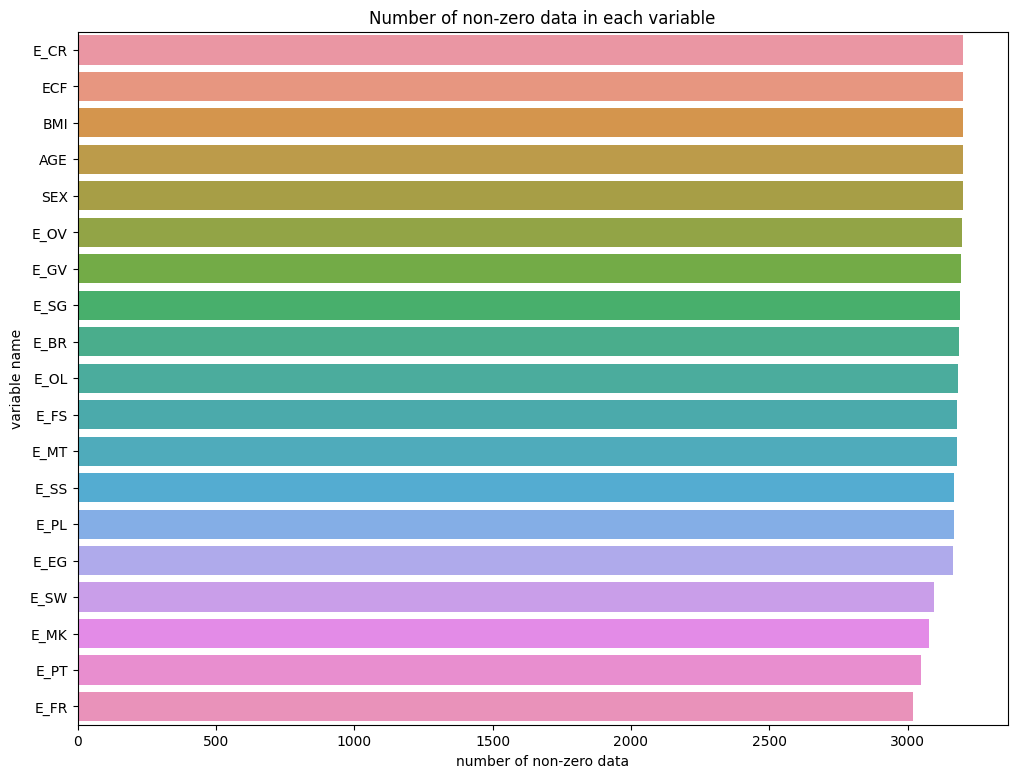

('E_GV', 'E_OV', 0.7040129248500424)
('E_GV', 'E_FR', 0.567757844868274)
('E_OV', 'E_GV', 0.7040129248500424)
('E_FR', 'E_GV', 0.567757844868274)
('E_MT', 'E_OL', 0.5948509316936996)
('E_OL', 'E_MT', 0.5948509316936996)


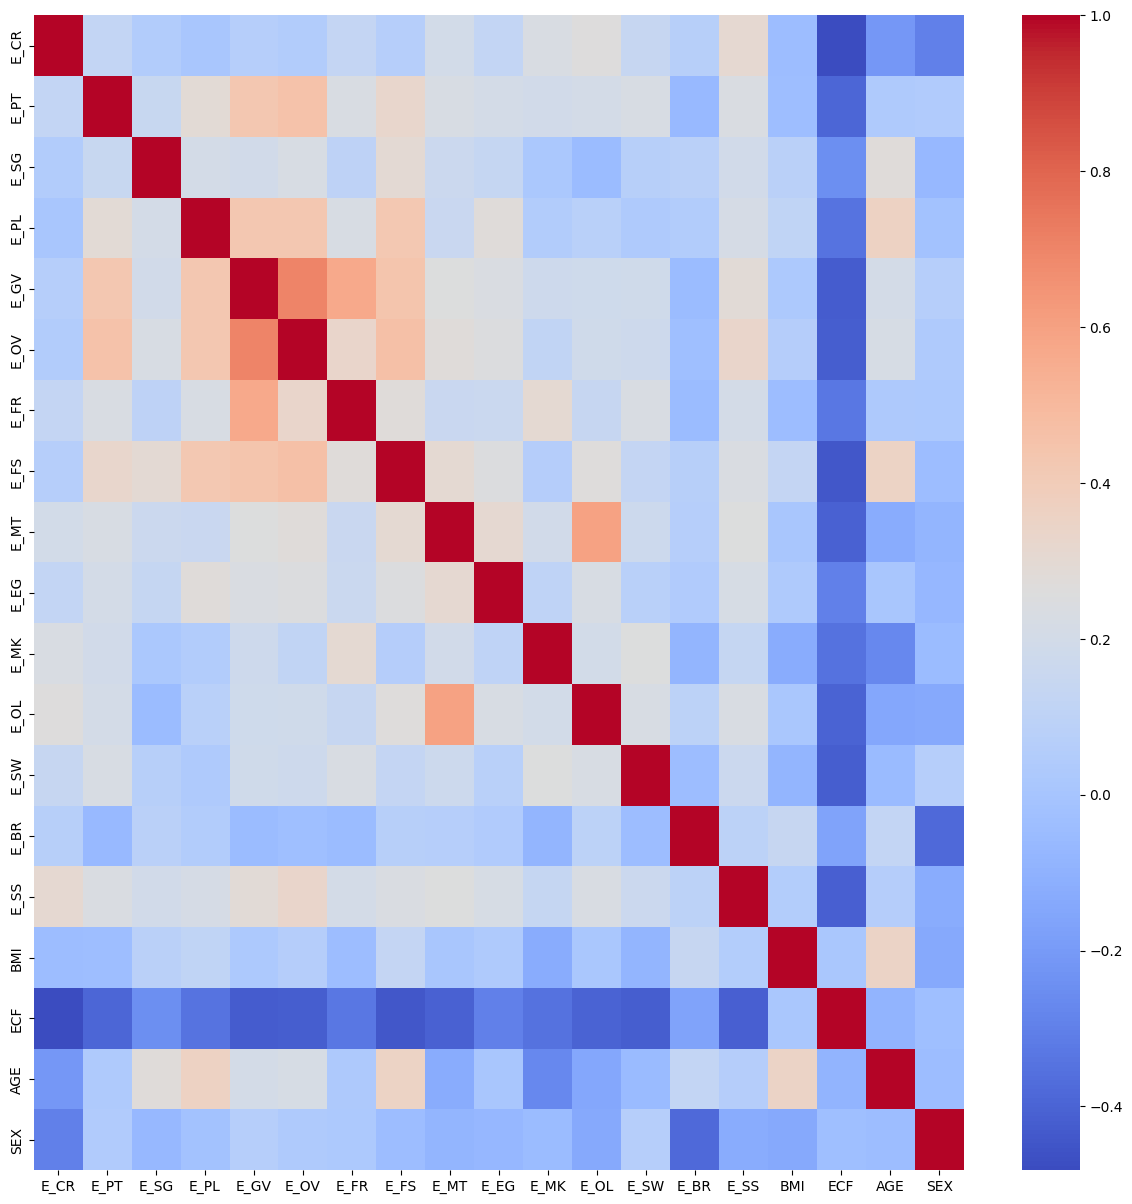

In [23]:
checksVariables(values_dataframe_cleaned)

### LiNGAMの関数定義

In [24]:
# 解析に使用する変数の選択（）
def select(df):
    # 基本統計量の確認
    df.describe()

    # 各列について、上:0.5%,下:0.5%のデータを外れ値として除去
    for column in df.columns:
        lower_limit = df[column].quantile(0.005)
        upper_limit = df[column].quantile(0.995)
        df = df[(df[column] > lower_limit) & (df[column] < upper_limit)]

    # 修正されたデータフレームを表示
    df.describe()

    len(df)

    return df

In [25]:
def modeling(selected_columns):
  # 標準化
  scaler = StandardScaler()
  Xy = scaler.fit_transform(selected_columns)

  # モデル作成
  model = lingam.DirectLiNGAM(random_state=1)
  model.fit(Xy)

  # 因果の順番
  print(f"因果の順番\n{model.causal_order_}\n\n")

  # 隣接行列
  print(f"隣接行列\n{model.adjacency_matrix_}\n\n")

  # 推定した因果モデルにおける、誤差同士の独立性のp値
  p_values = model.get_error_independence_p_values(Xy)
  print(f"推定した因果モデルにおける、誤差同士の独立性のp値\n{p_values}\n\n")

  return model

In [26]:
def gragh(model, selected_columns,dagname):
    # 因果グラフの描画
    dot = make_dot(model.adjacency_matrix_, labels=selected_columns.columns.to_list())
    dot.format = 'png'
    dot.render(dagname)
    return dot

In [27]:
def lingam_matrix(df):
    scaler = StandardScaler()
    Xy = scaler.fit_transform(df)

    model = lingam.DirectLiNGAM(random_state=1)
    result = model.bootstrap(Xy, n_sampling=100)
    # sklearn.utils.resampleで重複ありのリサンプリングをしている。リサンプル後のサンプル数は元データと同じ。

    # bootstrappingの各サンプルにおける、因果方向の有無のカウント結果を取得する
    cdc = result.get_causal_direction_counts(n_directions=8, min_causal_effect=0.01, split_by_causal_effect_sign=True)
    print_causal_directions(cdc, 100, labels=df.columns.to_list())

    # カウント結果を確率として、隣接行列の形式で表示
    prob = result.get_probabilities(min_causal_effect=0.01)
    print(prob)

    # bootstrappingの各サンプルにおける、DAG(Directed Acyclic Graphs)のカウント結果を取得する
    dagc = result.get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.01, split_by_causal_effect_sign=True)
    print_dagc(dagc, 100, labels=df.columns.to_list())

    # Total Causal Effects
    causal_effects = result.get_total_causal_effects(min_causal_effect=0.01)

    # Assign to pandas.DataFrame for pretty display
    causal_df = pd.DataFrame(causal_effects)
    labels = df.columns.to_list()
    # 'from' 列と 'to' 列のラベルを適用する
    causal_df['from'] = causal_df['from'].apply(lambda x: labels[x])
    causal_df['to'] = causal_df['to'].apply(lambda x: labels[x])
    return causal_df

In [28]:
def LiNGAM(df,dagname):
  selected_columns = select(df)
  model = modeling(selected_columns)
  dot = gragh(model, selected_columns,dagname)
  re_df = lingam_matrix(selected_columns)
  return dot,re_df

In [29]:
print(values_dataframe_cleaned.columns.tolist())

['E_CR', 'E_PT', 'E_SG', 'E_PL', 'E_GV', 'E_OV', 'E_FR', 'E_FS', 'E_MT', 'E_EG', 'E_MK', 'E_OL', 'E_SW', 'E_BR', 'E_SS', 'BMI', 'ECF', 'AGE', 'SEX']


In [33]:
# 変数を指定するリスト(そのほかの野菜、肉類)
selected_variables = ['E_CR', 'E_PT', 'E_SG', 'E_PL', 'E_GV', 'E_OV', 'E_FR', 'E_FS', 'E_MT', 'E_EG', 'E_MK', 'E_OL', 'E_SW', 'E_BR', 'E_SS', 'BMI', 'ECF','SEX']

# 使用する変数を確認
df = values_dataframe_cleaned[selected_variables]
df

,E_CR,E_PT,E_SG,E_PL,E_GV,E_OV,E_FR,E_FS,E_MT,E_EG,E_MK,E_OL,E_SW,E_BR,E_SS,BMI,ECF,SEX
0,611.084509,23.588095,31.238608,109.454936,38.207538,22.599505,110.037211,147.662474,136.211597,49.326816,355.077844,106.064037,222.419231,119.508270,110.409701,22.340297,1.231252,1.0
1,1013.089369,108.112104,16.799413,76.333603,23.460290,57.120557,13.387874,69.150696,181.621688,90.432496,398.285416,164.775112,261.748154,111.844019,128.299368,29.384757,0.980858,1.0
2,884.323748,19.656746,16.524739,10.909131,23.471166,30.071318,37.378482,57.835753,104.559746,115.095904,182.983383,107.696120,198.404738,47.798626,25.686451,19.568236,1.422898,1.0
3,1601.708395,58.970238,13.653344,13.090957,39.616248,52.605939,0.000000,348.983795,377.546144,138.115085,43.159727,209.556884,392.420910,179.581684,128.894541,25.854639,0.736540,1.0
4,901.041993,108.112104,26.510148,46.333493,41.543150,39.087465,93.085499,483.138811,224.499225,126.605495,199.094038,164.263920,208.421309,96.885391,116.787423,23.214198,0.934649,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3295,873.240080,18.701970,0.103321,67.972343,1.736734,0.000000,9.105204,20.382684,89.726897,107.104834,411.826698,8.055577,0.000000,11.019537,51.610540,15.061332,1.212149,1.0
3297,946.092537,63.941622,12.141975,97.234974,41.916822,44.823921,127.511899,102.211936,146.941214,98.275572,465.925694,95.514960,369.883019,262.502079,62.116778,15.320256,0.629887,2.0
3300,597.962406,22.231925,2.959305,6.508316,3.414781,5.591090,3.898818,24.556627,47.195073,14.039367,54.448262,39.113056,164.069386,250.066547,28.135001,18.668680,1.463388,2.0
3301,2026.844164,48.312578,16.374471,62.274240,37.475639,37.333737,147.658258,233.741491,243.018304,76.503453,769.581669,208.171341,200.073685,91.998357,71.471038,19.113632,0.473432,1.0


In [34]:
# 0data削除
df_filtered = df[(df != 0).all(axis=1)]

# 結果を表示
print(df_filtered.describe())

              E_CR         E_PT         E_SG         E_PL         E_GV  \
count  2690.000000  2690.000000  2690.000000  2690.000000  2690.000000   
mean    725.025968    54.122600    18.269948    74.639550    34.210648   
std     359.131586    44.767724    14.080011    54.038812    22.484622   
min      36.355230     5.071666     0.068914     3.526533     0.323022   
25%     508.129195    19.656746     8.251870    32.825087    18.424736   
50%     670.418195    44.227679    15.253344    61.333836    29.045626   
75%     852.324109    76.592308    24.135243   108.091883    44.586210   
max    5202.143086   330.233334   116.520544   432.728702   166.758571   

              E_OV         E_FR         E_FS         E_MT         E_EG  \
count  2690.000000  2690.000000  2690.000000  2690.000000  2690.000000   
mean     40.305422    49.802944   150.816267   142.783395    63.520024   
std      25.546569    46.826715   123.033226    87.506299    38.828927   
min       0.233749     2.560000     4

## 性別ごと

In [35]:
# 男女に分ける
male_df = df_filtered[df_filtered['SEX']==1].drop('SEX',axis=1)
female_df = df_filtered[df_filtered['SEX']==2].drop('SEX',axis=1)

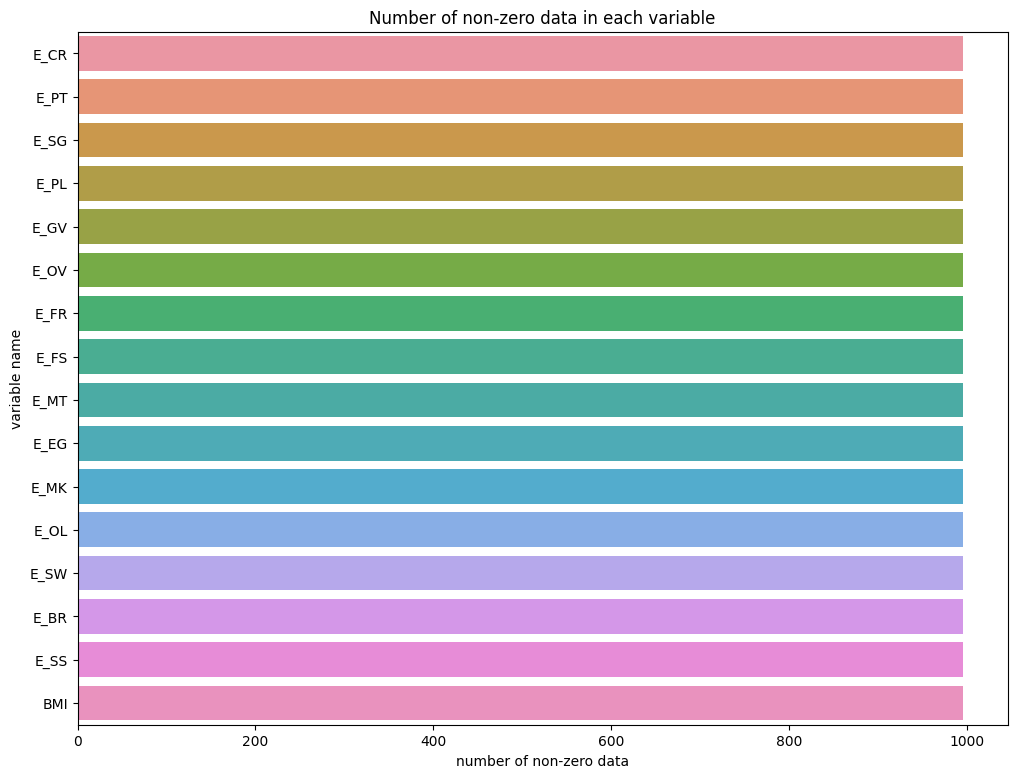

('E_GV', 'E_OV', 0.6154961230546672)
('E_GV', 'E_FR', 0.5138120623331291)
('E_OV', 'E_GV', 0.6154961230546672)
('E_FR', 'E_GV', 0.5138120623331291)


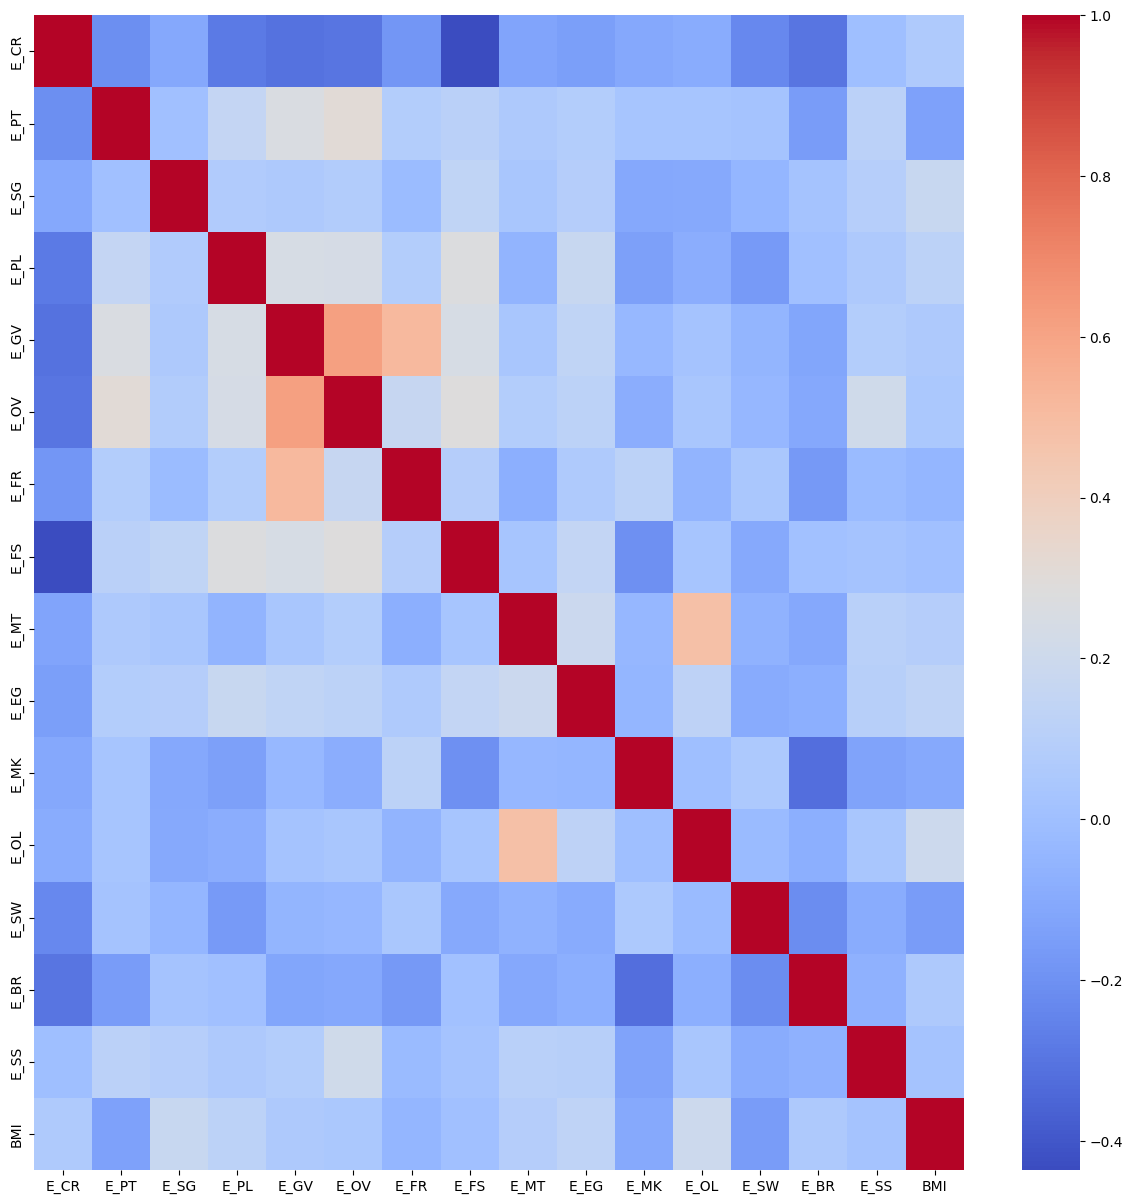

In [37]:
# 男性
multiplied_male_df = male_df.drop('ECF', axis=1).multiply(male_df['ECF'], axis=0)
# print(multiplied_male_df.describe())
checksVariables(multiplied_male_df)

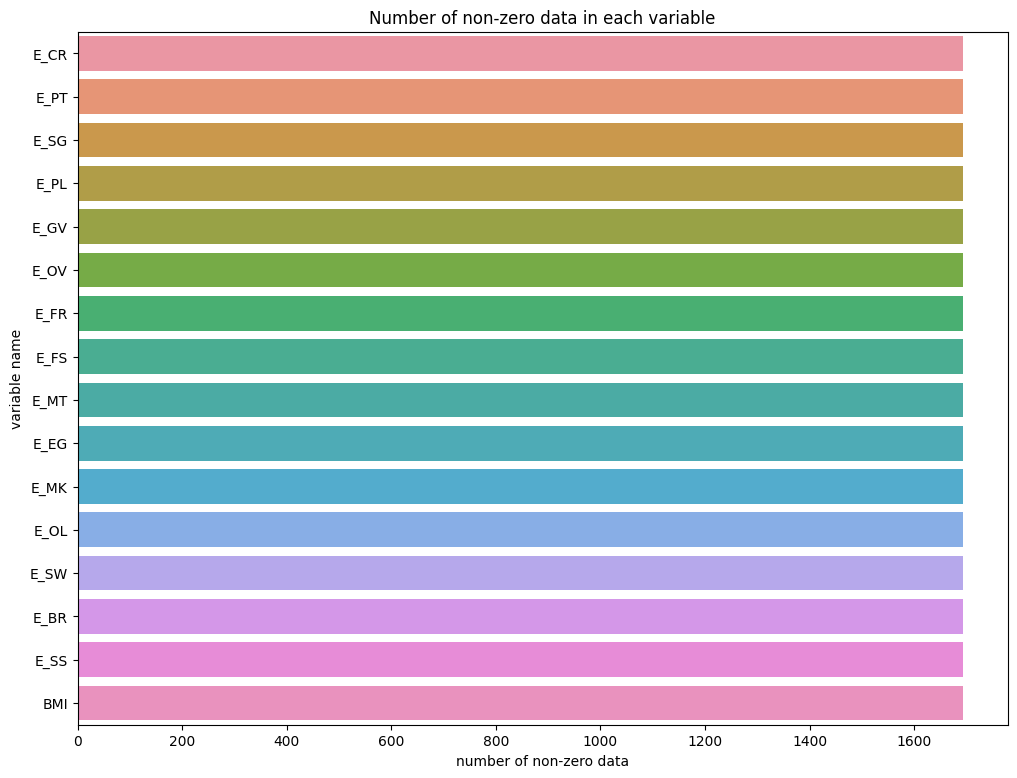

('E_GV', 'E_OV', 0.6074638587638953)
('E_OV', 'E_GV', 0.6074638587638953)


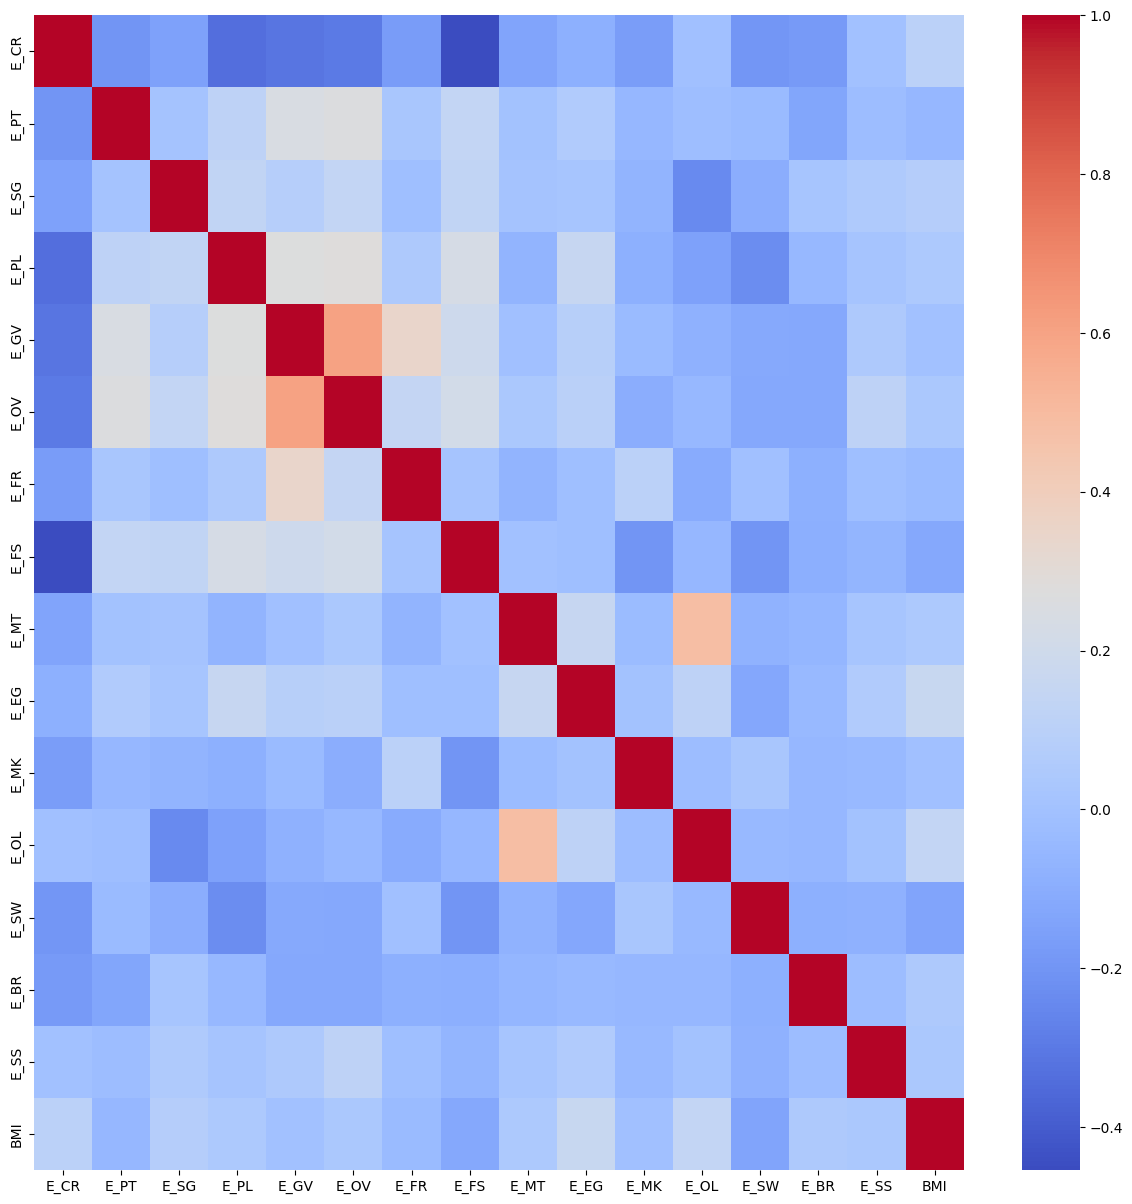

In [38]:
# 女性
multiplied_female_df = female_df.drop('ECF', axis=1).multiply(female_df['ECF'], axis=0)
# print(multiplied_female_df.describe())
checksVariables(multiplied_female_df)

因果の順番
[13, 6, 10, 7, 4, 3, 12, 14, 9, 8, 11, 2, 15, 1, 5, 0]


隣接行列
[[ 0.         -0.09553805 -0.07447433 -0.22476632 -0.10923112 -0.11523711
  -0.08786434 -0.36301503 -0.14206781 -0.06079487 -0.41276029 -0.06780771
  -0.39806503 -0.60294395  0.          0.08735477]
 [ 0.          0.          0.          0.          0.19941809  0.
   0.          0.          0.          0.          0.          0.
   0.         -0.12104699  0.11951576 -0.13052398]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.12800414  0.14521003  0.          0.         -0.25575801
   0.          0.          0.10273167  0.        ]
 [ 0.          0.          0.          0.          0.16724991  0.
   0.          0.19648344  0.          0.         -0.1071249   0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.47190253  0.18912693  0.          0.          0.          0.
   0.          0.          0.          0.   

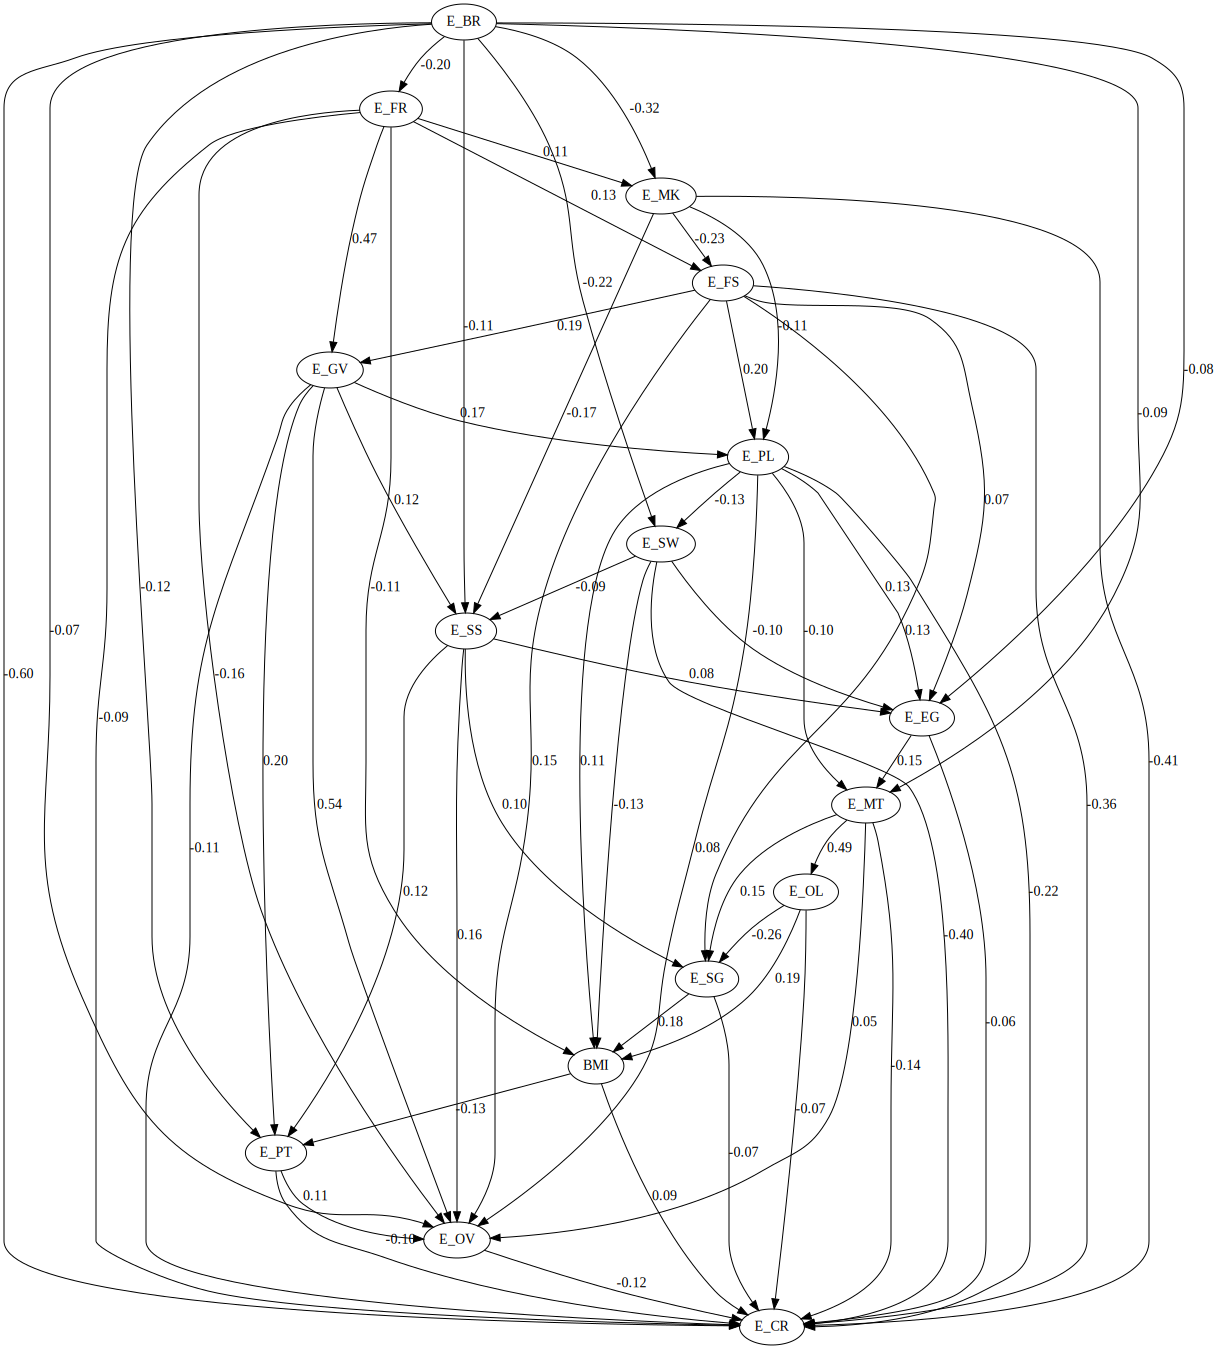

In [40]:
# 男性
dot_male,causal_df_male = LiNGAM(multiplied_male_df,'nutr_all_data')
dot_male

In [41]:
causal_df_male

,from,to,effect,probability
0,E_BR,E_SW,-0.224818,1.00
1,E_FR,E_GV,0.458934,1.00
2,E_BR,E_MK,-0.343505,1.00
3,E_BR,E_CR,-0.303932,1.00
4,E_FS,E_CR,-0.433782,1.00
...,...,...,...,...
207,E_MK,E_OL,-0.110325,0.01
208,E_FS,E_OL,0.108555,0.01
209,E_GV,E_OL,0.144301,0.01
210,E_OL,E_SS,0.104985,0.01


因果の順番
[13, 10, 14, 12, 7, 11, 8, 9, 3, 2, 6, 15, 1, 4, 5, 0]


隣接行列
[[ 0.         -0.11803465 -0.09816349 -0.29333195 -0.11129292 -0.10410824
  -0.11169324 -0.50008196 -0.14107403 -0.04863916 -0.32892255 -0.09323597
  -0.44863418 -0.32942863 -0.04330284  0.05043267]
 [ 0.          0.          0.          0.08384253  0.          0.
   0.          0.11900889  0.          0.06158421  0.          0.
   0.         -0.10292178  0.         -0.06573139]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.12647436  0.14643523  0.          0.         -0.31264031
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.17133568 -0.06322668  0.11699204 -0.08042818 -0.15844379
  -0.18489119  0.          0.          0.        ]
 [ 0.          0.2141995   0.          0.20553189  0.          0.
   0.3055344   0.10633798  0.          0.          0.          0.
   0.          0.          0.       

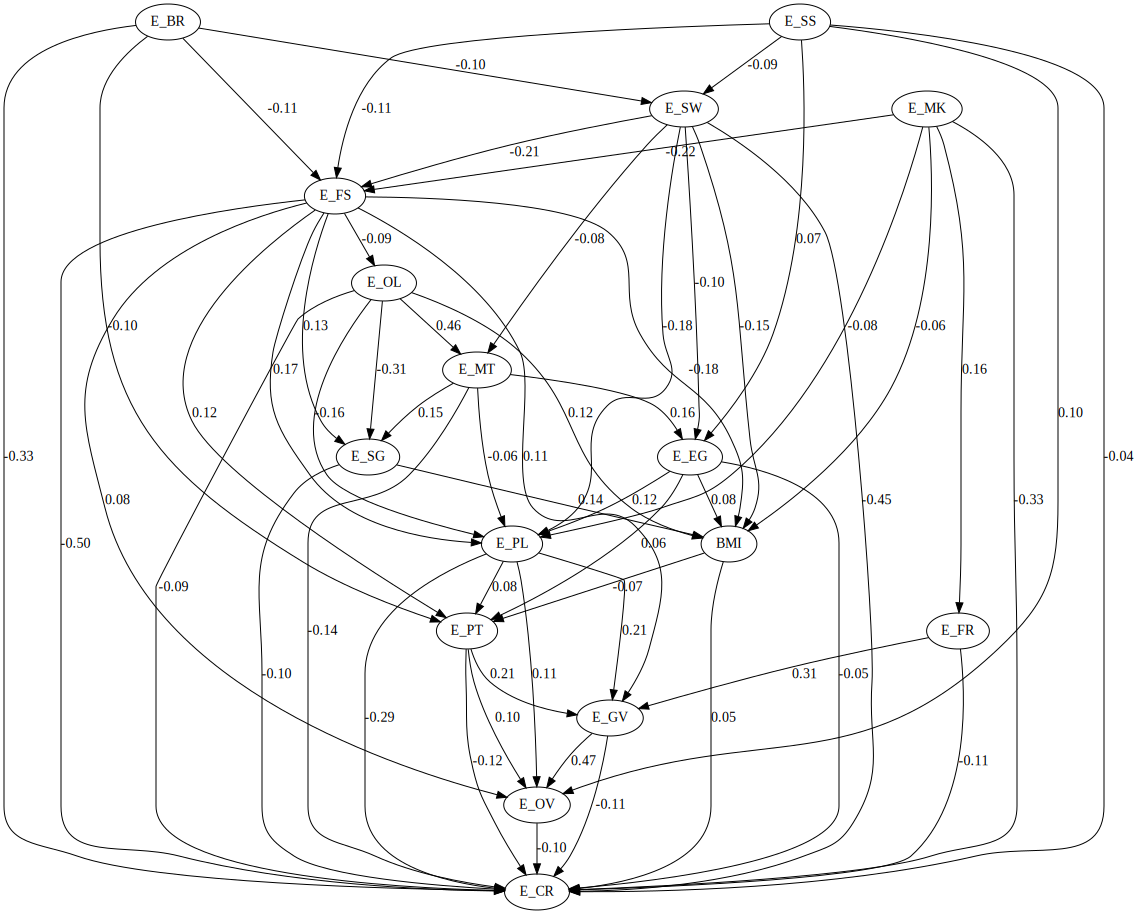

In [42]:
# 女性
dot_female,causal_df_female = LiNGAM(multiplied_female_df,'nutr_all_data')
dot_female

In [43]:
causal_df_female

,from,to,effect,probability
0,E_PT,E_CR,-0.170638,1.00
1,E_FS,E_SG,0.139076,1.00
2,E_BR,E_CR,-0.185405,1.00
3,E_SW,E_CR,-0.227978,1.00
4,E_MK,E_CR,-0.170934,1.00
...,...,...,...,...
199,BMI,E_SS,0.084421,0.01
200,E_BR,E_SS,0.086506,0.01
201,E_GV,E_MT,0.065817,0.01
202,E_FR,E_BR,-0.073484,0.01
